# Sanity check - Rolling method efficiency
Will test how well the agent preforms using different rolling methods to understand if exists any superior method.

## Final Report 

In [34]:
import numpy as np
import pandas as pd

np.random.seed(42)
N = 1000
noise = np.random.randn(N)
trend = np.linspace(0, 1, N)
signal = 0.2 * np.sin(np.linspace(0, 20, N))
price = 100 + trend + np.cumsum(noise + signal)

df = pd.DataFrame({'price': price})
window = 20

In [35]:
import numpy as np
import pandas as pd
from scipy.stats import mstats

def weighted_rolling_mean(series, window):
    weights = np.arange(1, window+1)
    return series.rolling(window).apply(lambda x: np.average(x, weights=weights), raw=True)

def rolling_winsorized_mean(series, window, limits=(0.1, 0.1)):
    def winsorized_mean(x):
        return mstats.winsorize(x, limits=limits).mean()
    return series.rolling(window).apply(winsorized_mean, raw=False)

def rolling_median(series, window):
    return series.rolling(window).median()

def rolling_mean(series, window):
    return series.rolling(window).mean()


In [39]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class RollingWindowRequiredEnv(gym.Env):
    
    """
    The agent receives a noisy observation of a hidden signal.
    The reward at each step is maximized if the agent predicts the
    rolling mean of the last N hidden values.
    """
    def __init__(self, seq_len=100, window=5, noise=0.2, regime_func=None):
        super().__init__()
        self.seq_len = seq_len
        self.window = window
        self.noise = noise
        self.current_step = 0
        self.regime_func = regime_func
        self.action_space = spaces.Box(low=-100.0, high=100.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        self._generate_series()

    def _get_obs(self):
        # Instead of just noisy obs, give the transformed feature
        start = max(0, self.current_step - self.window)
        window_series = self.obs_series[start:self.current_step]
        feature_val = self.regime_func(window_series) if len(window_series) == self.window else 0.0
        return np.array([feature_val], dtype=np.float32)


    def _generate_series(self):
        # The true series (hidden from agent)
        self.series = np.cumsum(np.random.randn(self.seq_len))
        # Observations (noisy)
        self.obs_series = self.series + np.random.normal(0, self.noise, self.seq_len)

    def reset(self, seed=None, options=None):
        self.current_step = self.window  # start after enough data
        self._generate_series()
        return self._get_obs(), {}


    def step(self, action):
        # Action: agent's guess of the rolling mean
        # True rolling mean (hidden)
        true_mean = self.series[self.current_step - self.window : self.current_step].mean()
        # Reward: negative absolute error (best if agent matches true mean)
        reward = -np.abs(action[0] - true_mean)
        self.current_step += 1
        done = self.current_step >= self.seq_len
        obs = self._get_obs() if not done else None
        return obs, reward, done, False, {}

    def render(self):
        print(f"Step {self.current_step}, obs={self.obs_series[self.current_step]}")



In [40]:
def rolling_mean(x): return np.mean(x)
def rolling_median(x): return np.median(x)
def rolling_weighted_mean(x): 
    weights = np.arange(1, len(x)+1)
    return np.average(x, weights=weights)
def rolling_winsorized_mean(x):
    from scipy.stats import mstats
    return mstats.winsorize(x, limits=(0.1,0.1)).mean()
    
regimes = {
    'rolling_mean': rolling_mean,
    'rolling_median': rolling_median,
    'rolling_weighted_mean': rolling_weighted_mean,
    'rolling_winsorized_mean': rolling_winsorized_mean,
}


In [41]:
import numpy as np
import torch
import random
import gym
from stable_baselines3 import PPO

results = {}

for SEED in [314, 42, 7]:
    print(f"\nSeed: {SEED}")
    np.random.seed(SEED)
    random.seed(SEED)
    torch.manual_seed(SEED)
    gym.utils.seeding.np_random(SEED)
    results[SEED] = {}
    # Train for each regime
    for train_name, train_func in regimes.items():
        print(f"Training with {train_name}")
        env_train = RollingWindowRequiredEnv(seq_len=200, window=5, noise=0.5, regime_func=train_func)
        model = PPO('MlpPolicy', env_train,policy_kwargs={"net_arch": [32, 32]}, verbose=0, seed=SEED)
        model.learn(total_timesteps=50000)
        results[SEED][train_name] = {}
        # Test for each regime
        for test_name, test_func in regimes.items():
            print(f"  Testing on {test_name}")
            env_test = RollingWindowRequiredEnv(seq_len=200, window=5, noise=0.5, regime_func=test_func)
            obs, _ = env_test.reset()
            done = False
            total_reward = 0
            while not done:
                action, _ = model.predict(obs)
                obs, reward, done, _, _ = env_test.step(action)
                total_reward += reward
            results[SEED][train_name][test_name] = total_reward


Seed: 314
Training with rolling_mean
  Testing on rolling_mean
  Testing on rolling_median
  Testing on rolling_weighted_mean
  Testing on rolling_winsorized_mean
Training with rolling_median
  Testing on rolling_mean
  Testing on rolling_median
  Testing on rolling_weighted_mean
  Testing on rolling_winsorized_mean
Training with rolling_weighted_mean
  Testing on rolling_mean
  Testing on rolling_median
  Testing on rolling_weighted_mean
  Testing on rolling_winsorized_mean
Training with rolling_winsorized_mean
  Testing on rolling_mean
  Testing on rolling_median
  Testing on rolling_weighted_mean
  Testing on rolling_winsorized_mean

Seed: 42
Training with rolling_mean
  Testing on rolling_mean
  Testing on rolling_median
  Testing on rolling_weighted_mean
  Testing on rolling_winsorized_mean
Training with rolling_median
  Testing on rolling_mean
  Testing on rolling_median
  Testing on rolling_weighted_mean
  Testing on rolling_winsorized_mean
Training with rolling_weighted_mean
 

In [42]:
import pandas as pd

# Summarize (average across seeds)
summary = {}
for train_regime in regimes:
    summary[train_regime] = {}
    for test_regime in regimes:
        vals = [results[seed][train_regime][test_regime] for seed in results]
        summary[train_regime][test_regime] = np.mean(vals)

df = pd.DataFrame(summary).T
print("Mean total reward (rows=train regime, cols=test regime):")
df

Mean total reward (rows=train regime, cols=test regime):


,rolling_mean,rolling_median,rolling_weighted_mean,rolling_winsorized_mean
rolling_mean,-1263.930319,-1036.251785,-1431.248287,-1736.720491
rolling_median,-1264.515481,-1036.853113,-1431.865071,-1737.242366
rolling_weighted_mean,-1264.258799,-1036.569385,-1431.550376,-1736.987335
rolling_winsorized_mean,-1263.930319,-1036.251785,-1431.248287,-1736.720491


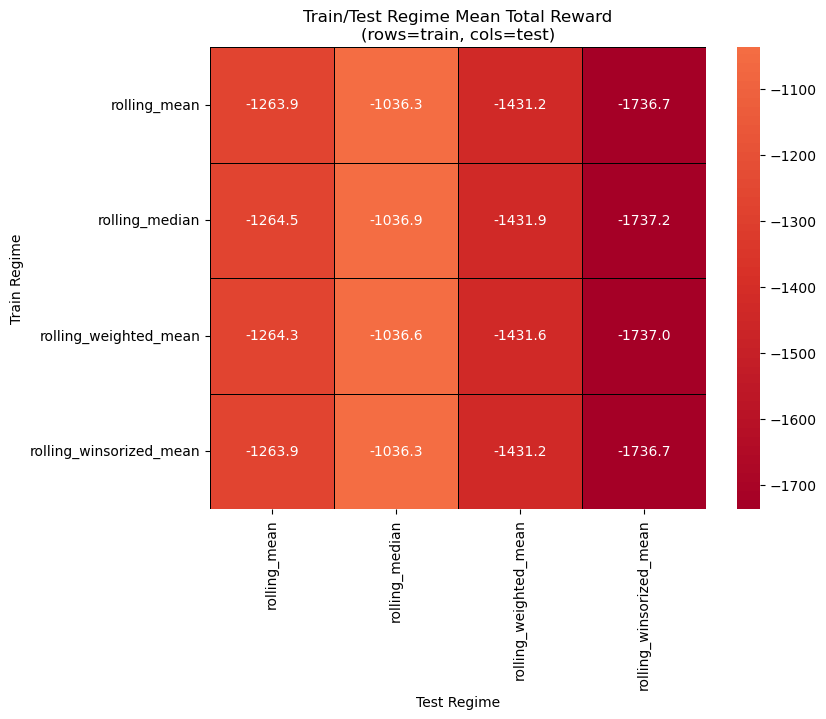

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(
    df,
    annot=True, fmt=".1f", cmap="RdYlGn", center=0,
    linewidths=0.5, linecolor='black'
)
plt.title("Train/Test Regime Mean Total Reward\n(rows=train, cols=test)")
plt.xlabel("Test Regime")
plt.ylabel("Train Regime")
plt.show()


In [44]:
df["Train avg"] = df.mean(axis=1)
df.loc["Test avg"] = df.mean(axis=0)
display(df)

,rolling_mean,rolling_median,rolling_weighted_mean,rolling_winsorized_mean,Train avg
rolling_mean,-1263.930319,-1036.251785,-1431.248287,-1736.720491,-1367.037720
rolling_median,-1264.515481,-1036.853113,-1431.865071,-1737.242366,-1367.619008
rolling_weighted_mean,-1264.258799,-1036.569385,-1431.550376,-1736.987335,-1367.341474
rolling_winsorized_mean,-1263.930319,-1036.251785,-1431.248287,-1736.720491,-1367.037720
Test avg,-1264.158730,-1036.481517,-1431.478005,-1736.917671,-1367.258981


In [ ]:
"""
What to Look For
Greener cells = better agent performance

Diagonal: Generalization to same regime

Off-diagonal: Generalization across regimes
"""